# Analysis of SAAF vs NDA

In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pandas as pd

from gallo.formulations.nda import NDA
from gallo.formulations.saaf import SAAF
from gallo.formulations.diffusion import Diffusion
from gallo.fe import *
from gallo.materials import Materials
from gallo.problem import Problem
from gallo.plot import plot, plot_1d
from gallo.solvers import Solver

## Setup Problem

In [ ]:
mesh = 'symmetric-8'
mat = 'scattering1g'

In [ ]:
nodefile = "../test/test_inputs/" + mesh + ".node"
elefile = "../test/test_inputs/" + mesh + ".ele"
matfile = "../test/test_inputs/" + mat + ".mat"
grid = FEGrid(nodefile, elefile)
mats = Materials(matfile)
num_elts = grid.num_elts
num_groups = mats.get_num_groups()
source = np.ones((num_groups, num_elts))

### Diffusion

In [ ]:
op = Diffusion(grid, mats)
solver = Solver(op)

In [ ]:
phi_diffusion = solver.solve(source)

### NDA

In [ ]:
op = NDA(grid, mats)
solver = Solver(op)

In [ ]:
phi_nda = solver.solve(source)

### SAAF

In [ ]:
op = SAAF(grid, mats)
solver = Solver(op)

In [ ]:
phi_saaf = solver.solve(source)

### Fix y to plot 1d solution

In [ ]:
y = 0.5

In [ ]:
diff_points = plot_1d(grid, phi_diffusion[0], y)
#nda_points = plot_1d(grid, phi_nda[0], y)
#saaf_points = plot_1d(grid, phi_saaf[0][0], y)
plt.plot(diff_points[:, 0], diff_points[:, 1], label='diffusion')
#plt.plot(nda_points[:, 0], nda_points[:, 1], label='nda')
#plt.plot(saaf_points[:, 0], saaf_points[:, 1], label='saaf')
plt.legend()
plt.ylabel("Scalar Flux")
plt.xlabel("x-axis")
plt.title("Scattering1g Solution at y=0.5")
plt.show()

In [ ]:
y = .25
diff_points = plot_1d(grid, phi_diffusion[0], y)
nda_points = plot_1d(grid, phi_nda[0], y)
saaf_points = plot_1d(grid, phi_saaf[0][0], y)
plt.plot(diff_points[:, 0], diff_points[:, 1], label='diffusion')
plt.plot(nda_points[:, 0], nda_points[:, 1], label='nda')
plt.plot(saaf_points[:, 0], saaf_points[:, 1], label='saaf')
plt.legend()
plt.ylabel("Scalar Flux")
plt.xlabel("x-axis")
plt.title("Scattering1g Solution at y=0.25")
plt.show()

## Compare SAAF & NDA as Mesh refines

In [3]:
x = np.arange(4, 8)
err = []
nda = []
saaf = []
for mesh in x:
    # Choose Input
    mesh = 'symmetric-%s' % (str(mesh))
    mat = 'scattering1g'

    # Setup Problem
    nodefile = "../test/test_inputs/" + mesh + ".node"
    elefile = "../test/test_inputs/" + mesh + ".ele"
    matfile = "../test/test_inputs/" + mat + ".mat"
    grid = FEGrid(nodefile, elefile)
    mats = Materials(matfile)
    num_elts = grid.num_elts
    num_groups = mats.get_num_groups()
    source = np.ones((num_groups, num_elts))

    # Solve NDA
    op = NDA(grid, mats)
    solver = Solver(op)
    nda_phis = solver.solve(source)
    nda.append(nda_phis[0])

    # Solve SAAF
    op = SAAF(grid, mats)
    solver = Solver(op)
    saaf_phis = solver.solve(source)
    saaf.append(saaf_phis[0][0])

nda = np.array(nda)
saaf = np.array(saaf)

Within-Group Iteration:  0
Norm:  0.7294488175206812
Within-Group Iteration:  1
Norm:  0.001539833360637986
Within-Group Iteration:  2
Norm:  5.083159629718298e-06
Within-Group Iteration:  3
Norm:  1.8564484986584605e-08
Number of Within-Group Iterations:  4
Final Phi Norm:  1.8564484986584605e-08
Runtime: 1.83269 seconds
Within-Group Iteration:  0
Norm:  0.500163232465444
Within-Group Iteration:  1
Norm:  0.22954207308000307
Within-Group Iteration:  2
Norm:  0.12010866834903684
Within-Group Iteration:  3
Norm:  0.10342658753404091
Within-Group Iteration:  4
Norm:  0.08264710587157194
Within-Group Iteration:  5
Norm:  0.06413808317733564
Within-Group Iteration:  6
Norm:  0.05204220765146981
Within-Group Iteration:  7
Norm:  0.045433072096086546
Within-Group Iteration:  8
Norm:  0.03843744879970967
Within-Group Iteration:  9
Norm:  0.0317447215733708
Within-Group Iteration:  10
Norm:  0.025731246722702824
Within-Group Iteration:  11
Norm:  0.020554271536693872
Within-Group Iteration:  1

Norm:  0.0003060939039545682
Within-Group Iteration:  28
Norm:  0.00023300707018504454
Within-Group Iteration:  29
Norm:  0.0001773285941854613
Within-Group Iteration:  30
Norm:  0.00013492887472143762
Within-Group Iteration:  31
Norm:  0.0001026512773475675
Within-Group Iteration:  32
Norm:  7.808553521543447e-05
Within-Group Iteration:  33
Norm:  5.939286990139879e-05
Within-Group Iteration:  34
Norm:  4.517145283278943e-05
Within-Group Iteration:  35
Norm:  3.435315656683679e-05
Within-Group Iteration:  36
Norm:  2.6124471885164305e-05
Within-Group Iteration:  37
Norm:  1.9866026724047335e-05
Within-Group Iteration:  38
Norm:  1.5106386959869572e-05
Within-Group Iteration:  39
Norm:  1.1486800082397681e-05
Within-Group Iteration:  40
Norm:  8.734310058157238e-06
Within-Group Iteration:  41
Norm:  6.641267990661109e-06
Within-Group Iteration:  42
Norm:  5.0497244829595534e-06
Within-Group Iteration:  43
Norm:  3.839545110747954e-06
Within-Group Iteration:  44
Norm:  2.919363597132657

In [ ]:
err = []
for i in range(7):
    err.append(np.mean(np.abs(nda[i] - saaf[i])))
err = np.array(err)
x = 2**x

In [ ]:
plt.loglog(x, err, linestyle="--", marker='o')
plt.title("Mean Difference SAAF vs. NDA with Mesh Refinement")
plt.ylabel("Absolute Value of Mean Difference")
plt.xlabel("Number of Mesh Cells")
plt.show()

In [4]:
def calculate_absorption(grid, mats, phi, group_id):
    triang = grid.setup_triangulation()
    integral = 0
    for elt in range(grid.num_elts):
        midx = grid.get_mat_id(elt)
        sig_a = mats.get_siga(midx, group_id)
        g_nodes = grid.gauss_nodes(elt)
        phi_vals = grid.phi_at_gauss_nodes(triang, phi, g_nodes)
        integral += grid.gauss_quad(elt, sig_a*phi_vals[0])
    return integral

In [5]:
mesh = 'symmetric-10'
mat = 'scattering1g'
nodefile = "../test/test_inputs/" + mesh + ".node"
elefile = "../test/test_inputs/" + mesh + ".ele"
matfile = "../test/test_inputs/" + mat + ".mat"
grid = FEGrid(nodefile, elefile)
mats = Materials(matfile)

In [7]:
op = SAAF(grid, mats)
solver = Solver(op)
num_elts = grid.num_elts
num_groups = mats.get_num_groups()
source = np.ones((num_groups, num_elts))
reference = solver.solve(source)


Within-Group Iteration:  0
Norm:  0.8460897623293254
Within-Group Iteration:  1
Norm:  0.26679989586841096
Within-Group Iteration:  2
Norm:  0.1627671305835095
Within-Group Iteration:  3
Norm:  0.11574100738371519
Within-Group Iteration:  4
Norm:  0.0879447927952707
Within-Group Iteration:  5
Norm:  0.06824468882999961
Within-Group Iteration:  6
Norm:  0.05418317283752738
Within-Group Iteration:  7
Norm:  0.04356158932573785
Within-Group Iteration:  8
Norm:  0.03534895368497953
Within-Group Iteration:  9
Norm:  0.028949410548973247
Within-Group Iteration:  10
Norm:  0.02346245564025232
Within-Group Iteration:  11
Norm:  0.01881153500507019
Within-Group Iteration:  12
Norm:  0.014944970856984978
Within-Group Iteration:  13
Norm:  0.011782355688190775
Within-Group Iteration:  14
Norm:  0.009230062966142342
Within-Group Iteration:  15
Norm:  0.007192841344695883
Within-Group Iteration:  16
Norm:  0.005581228843658597
Within-Group Iteration:  17
Norm:  0.004315522091696748
Within-Group Ite

ValueError: could not broadcast input array from shape (545) into shape (1)

In [8]:
reference_abs = calculate_absorption(grid, mats, reference[0], 0)

In [9]:
nda_abs = []
saaf_abs = []
x = np.arange(4, 8)
for i, mesh in enumerate(x):
    # Choose Input
    mesh = 'symmetric-%s' % (str(mesh))
    mat = 'scattering1g'

    # Setup Problem
    nodefile = "../test/test_inputs/" + mesh + ".node"
    elefile = "../test/test_inputs/" + mesh + ".ele"
    matfile = "../test/test_inputs/" + mat + ".mat"
    grid = FEGrid(nodefile, elefile)
    mats = Materials(matfile)

    flux_nda = np.array([nda[i]])
    flux_saaf = np.array([saaf[i]])
    nda_abs.append(calculate_absorption(grid, mats, flux_nda, 0))
    saaf_abs.append(calculate_absorption(grid, mats, flux_saaf, 0))
    

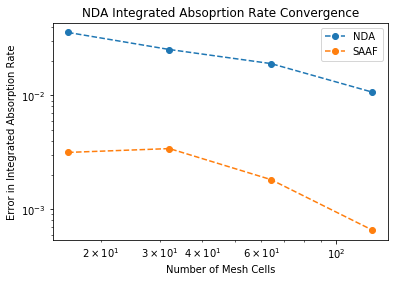

In [10]:
cells = 2**x
absorption_error_nda = np.abs(nda_abs - reference_abs)
absorption_error_saaf = np.abs(saaf_abs - reference_abs)
plt.loglog(cells, absorption_error_nda, marker='o', linestyle="--", label="NDA")
plt.loglog(cells, absorption_error_saaf, marker='o', linestyle="--", label="SAAF")
plt.xlabel("Number of Mesh Cells")
plt.ylabel("Error in Integrated Absorption Rate")
plt.title("NDA Integrated Absoprtion Rate Convergence")
plt.legend()
plt.show()